# BERT News Classifier

In [1]:
! pip install transformers torch

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
data_path = '/content/gdrive/MyDrive/Colab_Notebooks/DL_Basics_in_NLP_Stepik_HSE/News_Classification_Kaggle'

In [2]:
import os
import pandas as pd
import numpy as np
import json
import re
import string
from string import punctuation
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig
from sklearn.model_selection import train_test_split

import torch
import json
from torch.utils.data import Dataset
from typing import Dict
from numpy import asarray
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW, SGD, Rprop, Adadelta, Adamax, SparseAdam, NAdam, RAdam
from tqdm.notebook import tqdm
#from textblob import TextBlob

torch.manual_seed(42)

In [3]:
train_data = pd.read_csv(os.path.join(data_path, "full_news_2.csv"))
test_data =  pd.read_csv(os.path.join(data_path,'test_news.csv'))

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160990 entries, 0 to 160989
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  160990 non-null  object
 1   topic    160990 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26275 entries, 0 to 26274
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  26275 non-null  object
dtypes: object(1)
memory usage: 205.4+ KB


In [6]:
train_data.topic.value_counts(normalize=True)

0    0.310044
1    0.137965
3    0.133698
4    0.108976
5    0.074626
2    0.073787
8    0.069489
7    0.068681
6    0.022734
Name: topic, dtype: float64

In [7]:
test_data.head()

,content
0,Фото: «Фонтанка.ру»ПоделитьсяЭкс-министру обор...
1,В начале февраля 2023 года в Пушкинском районе...
2,Фото: Andy Bao / Getty Images Анастасия Борисо...
3,"Если вы хотели, но так и не съездили на море л..."
4,Сергей Пиняев Фото: Алексей Филиппов / РИА Нов...


## Preprocess Text

In [8]:
def clean_text(text):
    text = re.sub(r"^[А-ЯЁ]{3,}.{2,}\W{2}РИА Новости, [\w\s,]+\.", "", text)
    text = re.sub(r"^[А-ЯЁ]{3,}.{2,}\W{2}РИА Новости\.", "", text)
    #text = re.sub (r'Фото: [A-ZА-Я][а-яa-z]+ [АA-ЯZ][а-яa-z]+ \/', ' ', text)
    text = re.sub (r'«Лента.ру»|Лента.ру|«Фонтанка.ру»|Фонтанка.ру|РИА Новости|ТАСС|[Rr]euters|Unsplash|Globallookpress.com|Global Look Press|Shutterstock|memomemory|Handout|Pixabay|Wikimedia|Getty Images|«Коммерсантъ»|Коммерсантъ', '', text)
    text = re.sub(r'Фото:[^\.!?]*Поделиться', ' ', text)  #После фото может быть все, кроме маркеров конца предложения
    text = re.sub(r'\/', '', text)
    text = re.sub(r'Фото:', '', text)
    text = re.sub(r'Кадр:', '', text)
    text = re.sub(r'^Поделиться', '', text)
    text = re.sub(r'http[^А-Я]+', ' ', text)
    text = re.sub(r'[\n\t]+',' ', text)
    text = re.sub(r'\d+', '1', text)
    text = re.sub(r'\xa0', ' ', text)
    text = re.sub(r'©', '', text)
    text = re.sub(r'ё', 'е', text)
    return text.lower().strip()

In [9]:
%%time
train_data['content_clean'] = train_data.content.apply(clean_text)
test_data['content_clean'] = test_data.content.apply(clean_text)

CPU times: user 42.8 s, sys: 367 ms, total: 43.1 s
Wall time: 43.1 s


In [10]:
train_data.head()

,content,topic,content_clean
0,Лика Миргородская Пожар в сочинском лесу близ ...,0,лика миргородская пожар в сочинском лесу близ ...
1,Фото: Telegram-канал BAZA Лика Миргородская Те...,0,telegram-канал baza лика миргородская террорис...
2,Владимир Зеленский Фото: Valentyn Ogirenko / R...,3,владимир зеленский valentyn ogirenko лика м...
3,Фото: Владимир Песня / РИА Новости Илья Соболе...,0,владимир песня илья соболев в россии 1 январ...
4,Фото: Павел Бедняков / РИА Новости Милана Мика...,0,павел бедняков милана микаилова директор деп...


In [12]:
train_data.content_clean.apply(lambda x: len(x) == 0).sum()

6

In [13]:
train_data[train_data.content_clean.apply(lambda x: len(x) == 0)]

,content,topic,content_clean
137483,http://fontankafi.ru/articles/15353/,7,
137680,http://fontankafi.ru/articles/4310/,7,
137718,http://fontankafi.ru/articles/2547/,7,
141091,http://www.47news.ru/1/9966/,4,
141387,http://www.47news.ru/1/4898/,4,
141891,http://nevastroyka.ru/a0/ru/archive/view.thtml...,4,


In [15]:
test_data.content_clean.apply(lambda x: len(x) == 0).sum()

0

In [14]:
train_data = train_data[~train_data.content_clean.apply(lambda x: len(x) == 0)]
train_data.shape

(160984, 3)

## Define model

Some of this code I borrowed from the finished course by Valentin Malykh ([Natural Language Processing Course, stream 5, autumn 2023](https://ods.ai/tracks/nlp-course-autumn-23)).

To concatenate 4 hidden layers of BERT I researched this [notebook](https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently).  

In [15]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_seq_len):
        self.data = dataframe
        self.text = dataframe['content_clean'].tolist()
        self.targets = None
        if 'topic' in dataframe:
            self.targets = dataframe['topic'].tolist()
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_seq_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        if self.targets is not None:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'targets': torch.tensor(self.targets[index], dtype=torch.long)
            }
        else:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
            }

    def __len__(self) -> int:
        return len(self.text)


class ModelForClassification(torch.nn.Module):

    def __init__(self, model_path: str, config: Dict, custom_config: Dict):
        super(ModelForClassification, self).__init__()
        self.model_name = model_path
        self.config = config
        self.custom_config = custom_config
        self.n_classes = custom_config['num_classes']
        self.dropout_rate = custom_config['dropout_rate']
        self.bert = AutoModel.from_pretrained(self.model_name, output_hidden_states=True)
        self.pre_classifier = torch.nn.Linear(self.config.hidden_size*4, 768)
        self.dropout = torch.nn.Dropout(self.dropout_rate)
        self.classifier = torch.nn.Linear(768, self.n_classes)
        self.softmax = torch.nn.LogSoftmax(dim = 1)

    def forward(self, input_ids, attention_mask,):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        all_hidden_states = torch.stack(output[2])
        concatenate_pooling = torch.cat((all_hidden_states[-1],
                                         all_hidden_states[-2],
                                         all_hidden_states[-3],
                                        all_hidden_states[-4]),-1)
        concatenate_pooling = concatenate_pooling[:, 0]
        logits = self.pre_classifier(concatenate_pooling) # regression head
        relu_state = torch.nn.ReLU()(logits)
        dropout_state = self.dropout(relu_state)
        output = self.classifier(dropout_state)
        output = self.softmax(output)
        return output

class Trainer:
    def __init__(self, config: Dict, class_weights=None):
        self.config = config
        self.device = config['device']
        self.n_epochs = config['n_epochs']
        self.optimizer = None
        self.opt_fn = lambda model: Adamax(model.parameters(), config['lr'])
        self.model = None
        self.history = None
        if class_weights is not None:
            class_weights = class_weights.to(self.device)
            self.loss_fn = CrossEntropyLoss(weight=class_weights)
        else:
            self.loss_fn = CrossEntropyLoss()
        self.device = config['device']
        self.verbose = config.get('verbose', True)

    def save_history(self, path: str):
        history = {
            'train_loss': self.history['train_loss'],
            'val_loss': self.history['val_loss'],
            'val_acc': self.history['val_acc']
        }
        val_acc = sum(self.history['val_acc']) / len(self.history['val_acc'])
        print("All ACCURACY = ", val_acc)
        with open(path, 'w') as file:
            json.dump(history, file)

    def load_history(self, path: str):
        with open(path, 'r') as file:
            history = json.load(file)
        self.history = {
            'train_loss': history['train_loss'],
            'val_loss': history['val_loss'],
            'val_acc': history['val_acc']
        }

    def fit(self, model, train_dataloader, val_dataloader):
        self.model = model.to(self.device)
        self.optimizer = self.opt_fn(model)
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': []
        }
        best_val_loss = float('inf')

        for epoch in range(self.n_epochs):
            print(f"Epoch {epoch + 1}/{self.n_epochs}")
            train_info = self.train_epoch(train_dataloader)
            val_info = self.val_epoch(val_dataloader)
            self.history['train_loss'].extend(train_info['loss'])
            self.history['val_loss'].extend([val_info['loss']])
            self.history['val_acc'].extend([val_info['acc']])

            if val_info['loss'] < best_val_loss:
                best_val_loss = val_info['loss']
                self.save_model_weights('best_model_weights.ckpt')

            self.save_history('history.json')

        return self.model.eval()

    def save_model_weights(self, path: str):
        torch.save(self.model.state_dict(), path)

    def train_epoch(self, train_dataloader):
        self.model.train()
        losses = []
        total_loss = 0
        if self.verbose:
            train_dataloader = tqdm(train_dataloader)
        for batch in train_dataloader:
            ids = batch['ids'].to(self.device, dtype=torch.long)
            mask = batch['mask'].to(self.device, dtype=torch.long)
            targets = batch['targets'].to(self.device, dtype=torch.long)

            outputs = self.model(ids, mask)
            loss = self.loss_fn(outputs, targets)
            total_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_val = loss.item()
            if self.verbose:
                train_dataloader.set_description(f"Loss={loss_val:.3}")
            losses.append(loss_val)
        avg_loss = total_loss / len(train_dataloader)
        print("AVG LOSS = ", avg_loss)
        return {'loss': losses}

    def val_epoch(self, val_dataloader):
        self.model.eval()
        all_logits = []
        all_labels = []
        if self.verbose:
            val_dataloader = tqdm(val_dataloader)
        with torch.no_grad():
            for batch in val_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                targets = batch['targets'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                all_logits.append(outputs)
                all_labels.append(targets)
        all_labels = torch.cat(all_labels).to(self.device)
        all_logits = torch.cat(all_logits).to(self.device)
        loss = self.loss_fn(all_logits, all_labels).item()
        acc = (all_logits.argmax(1) == all_labels).float().mean().item()
        print("ACCURACY for EPOCH = ", acc)
        #predicted_labels = all_logits.argmax(1).cpu().numpy()
        #true_labels = all_labels.cpu().numpy()
        #f1_weighted = f1_score(true_labels, predicted_labels, average='weighted')
        print(f"Loss={loss:.3}; Acc:{acc:.3}") #; F1 Weighted:{f1_weighted:.3}"
        if self.verbose:
            val_dataloader.set_description(f"Loss={loss:.3}; Acc:{acc:.3}")
        return {
            'acc': acc,
            'loss': loss
        }

    def predict(self, test_dataloader):
        if not self.model:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                preds = torch.exp(outputs)
                predictions.extend(preds.tolist())
        return asarray(predictions)

    def save(self, path: str):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        checkpoint = {
            "config": self.model.config,
            "trainer_config": self.config,
            "model_name": self.model.model_name,
            "model_state_dict": self.model.state_dict()
        }
        torch.save(checkpoint, path)

    def plot_history(self):
        import matplotlib.pyplot as plt

        if self.history is None:
            raise RuntimeError("History is not available. Train the model first.")

        train_loss = self.history['train_loss']
        val_loss = self.history['val_loss']
        val_acc = self.history['val_acc']

        epochs = range(1, len(train_loss) + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
        plt.title('Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()


    @classmethod
    def load(cls, path: str):
        ckpt = torch.load(path)
        keys = ["config", "trainer_config", "model_state_dict"]
        for key in keys:
            if key not in ckpt:
                raise RuntimeError(f"Missing key {key} in checkpoint")
        new_model = ModelForClassification(
            ckpt['model_name'],
            ckpt["config"]
        )
        new_model.load_state_dict(ckpt["model_state_dict"])
        new_trainer = cls(ckpt["trainer_config"])
        new_trainer.model = new_model
        new_trainer.model.to(new_trainer.device)
        return new_trainer

## Loading tokenizer from pretrained rubert-tiny2

In [16]:
tokenizer = AutoTokenizer.from_pretrained(
    "cointegrated/rubert-tiny2", truncation=True, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Train-Test Split

In [17]:
train_split, val_split = train_test_split(train_data, test_size=0.25, random_state=42,
                                          shuffle = True, stratify=train_data['topic'])

In [18]:
MAX_LEN = 512
BATCH_SIZE = 64
train_dataset = CustomDataset(train_split, tokenizer, MAX_LEN)
val_dataset = CustomDataset(val_split, tokenizer, MAX_LEN)
train_params = {"batch_size": BATCH_SIZE,
                "shuffle": True,
                "num_workers": 0
                }

test_params = {"batch_size": BATCH_SIZE,
               "shuffle": False,
               "num_workers": 0
               }

train_dataloader = DataLoader(train_dataset, **train_params)
val_dataloader = DataLoader(val_dataset, **test_params)

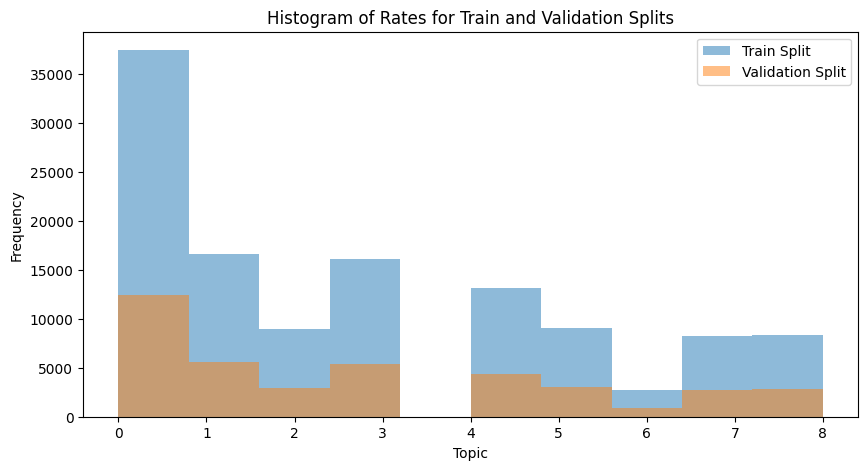

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(train_split['topic'], bins=10, alpha=0.5, label='Train Split')
plt.hist(val_split['topic'], bins=10, alpha=0.5, label='Validation Split')

plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Rates for Train and Validation Splits')

plt.show()

In [20]:
config = AutoConfig.from_pretrained("cointegrated/rubert-tiny2")
config.update({'output_hidden_states': True})

custom_config = {"num_classes":len(np.unique(train_split['topic'])),
               "dropout_rate": 0.1}

model = ModelForClassification(
    "cointegrated/rubert-tiny2",
    config=config,
    custom_config=custom_config
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Fit the model

In [21]:
trainer_config = {
    "lr": 3e-4,
    "n_epochs": 5,
    "weight_decay": 1e-6,
    "batch_size": BATCH_SIZE,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
}
t = Trainer(trainer_config)

t.fit(
    model,
    train_dataloader,
    val_dataloader
)

Epoch 1/5


  0%|          | 0/1887 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


AVG LOSS =  0.27418856253273977


  0%|          | 0/629 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.9360184669494629
Loss=0.179; Acc:0.936
All ACCURACY =  0.9360184669494629
Epoch 2/5


  0%|          | 0/1887 [00:00<?, ?it/s]

AVG LOSS =  0.149900056117732


  0%|          | 0/629 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.9442428946495056
Loss=0.154; Acc:0.944
All ACCURACY =  0.9401306807994843
Epoch 3/5


  0%|          | 0/1887 [00:00<?, ?it/s]

AVG LOSS =  0.11398441967207427


  0%|          | 0/629 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.9454107284545898
Loss=0.152; Acc:0.945
All ACCURACY =  0.9418906966845194
Epoch 4/5


  0%|          | 0/1887 [00:00<?, ?it/s]

AVG LOSS =  0.08739383144241969


  0%|          | 0/629 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.9452616572380066
Loss=0.167; Acc:0.945
All ACCURACY =  0.9427334368228912
Epoch 5/5


  0%|          | 0/1887 [00:00<?, ?it/s]

AVG LOSS =  0.06505185644098897


  0%|          | 0/629 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.9398698210716248
Loss=0.196; Acc:0.94
All ACCURACY =  0.942160713672638


ModelForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, element

In [22]:
test_dataset = CustomDataset(test_data, tokenizer, MAX_LEN)
test_dataloader = DataLoader(test_dataset, **test_params)
predictions = t.predict(test_dataloader)

In [23]:
predicted_classes = [np.argmax(probabilities) for probabilities in predictions]

In [24]:
submission = pd.read_csv(os.path.join(data_path, "base_submission_news.csv"))
submission['topic'] = predicted_classes
submission.head()

,topic,index
0,0,0
1,6,1
2,4,2
3,5,3
4,4,4


In [25]:
test_data.content.loc[1]

'В начале февраля 2023 года в Пушкинском районе Санкт-Петербурга введён в эксплуатацию новый малоэтажный жилой комплекс. Сведения об объекте капитального строительства внесены в специальный кадастр недвижимости.Фото: ООО «СЗ «ТЕРМИНАЛ-РЕСУРС»ПоделитьсяКадастровый учёт осуществляет Федеральная служба государственной регистрации, кадастра и картографии — Росреестр. Поставить дом на кадастровый учёт означает внести в базу его основные характеристики: наименование, адрес, назначение, этажность, ситуационный план, а также кадастровый номер. Это необходимо для оформления права собственности на объект недвижимости, а также последующего распоряжения собстве о договору купли-продажи. На готовые квартиры от застройщика распространяются все программы льготной ипотеки, как и на строящиеся объекты.Квартиры в Пушкинском районе: г. Санкт-Петербург, ул. Кокколевская, д.1, БЦ «Перспектива» (отдел продаж рядом с «Образцовыми кварталами»), +7 (812) 719–19–19, www.devcent.ruСправка о компании ООО «СЗ «Тер

In [26]:
submission.to_csv(os.path.join(data_path, "more_news_transformers_preds_02.csv"), index=False)

In [27]:
t.save(os.path.join(data_path, "tf_model_2.ckpt"))

Final Score on Kaggle - 0.93428.